In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve

# Load the dataset, specifying the encoding
df = pd.read_csv('/content/my1995-2004-fuel-consumption-ratings-5-cycle.csv', encoding='latin-1') # Try 'latin-1' encoding


Knowing data

In [2]:
# Display basic information about the dataset
print("Data shape:", df.shape)
print("Data preview:")
print(df.head())
print(df.isnull().sum())
print(df.dtypes)

# Summary statistics
summary_stats = df['CO2 emissions (g/km)'].describe()
print("Summary Statistics for CO2 emissions (g/km):\n", summary_stats)

Data shape: (27809, 13)
Data preview:
   Model year   Make         Model Vehicle class  Engine size (L)  Cylinders  \
0        1995  Acura       Integra    Subcompact              1.8          4   
1        1995  Acura       Integra    Subcompact              1.8          4   
2        1995  Acura  Integra GS-R    Subcompact              1.8          4   
3        1995  Acura        Legend       Compact              3.2          6   
4        1995  Acura  Legend Coupe       Compact              3.2          6   

  Transmission Fuel type  City (L/100 km)  Highway (L/100 km)  \
0           A4         X             11.6                 8.3   
1           M5         X             11.0                 8.3   
2           M5         Z             10.8                 8.3   
3           A4         Z             14.2                10.5   
4           A4         Z             14.6                11.0   

   Combined (L/100 km)  Combined (mpg)  CO2 emissions (g/km)  
0                 10.1     

In [3]:
# Check data types
print(df.info())

# Check for duplicates
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27809 entries, 0 to 27808
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            27809 non-null  int64  
 1   Make                  27809 non-null  object 
 2   Model                 27809 non-null  object 
 3   Vehicle class         27809 non-null  object 
 4   Engine size (L)       27809 non-null  float64
 5   Cylinders             27809 non-null  int64  
 6   Transmission          27809 non-null  object 
 7   Fuel type             27809 non-null  object 
 8   City (L/100 km)       27809 non-null  float64
 9   Highway (L/100 km)    27809 non-null  float64
 10  Combined (L/100 km)   27809 non-null  float64
 11  Combined (mpg)        27809 non-null  int64  
 12  CO2 emissions (g/km)  27809 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.8+ MB
None
0


In [4]:
# Check for negative values
for col in df.select_dtypes(include=['number']).columns:
  if (df [col]< 0).any().any():
    print("Negative values found in the DataFrame.")
else:
    print("No negative values found in the DataFrame.")


No negative values found in the DataFrame.


Feature Engineering

In [5]:
numerical_features = ['Engine size (L)', 'Cylinders', 'City (L/100 km)',
                     'Highway (L/100 km)', 'Combined (L/100 km)']  # numerical features
categorical_features = ['Make', 'Model', 'Vehicle class', 'Transmission', 'Fuel type']  # categorical features

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [6]:
categorical_columns = ['Make', 'Model', 'Vehicle class', 'Transmission', 'Fuel type']
numerical_columns = ['Engine size (L)', 'Cylinders', 'City (L/100 km)', 'Highway (L/100 km)', 'Combined (L/100 km)']

In [7]:
# Check for negative values
for col in df.select_dtypes(include=['number']).columns:
  if (df [col]< 0).any().any():
    print("Negative values found in the DataFrame.")
else:
    print("No negative values found in the DataFrame.")


No negative values found in the DataFrame.


Distrinution Plot

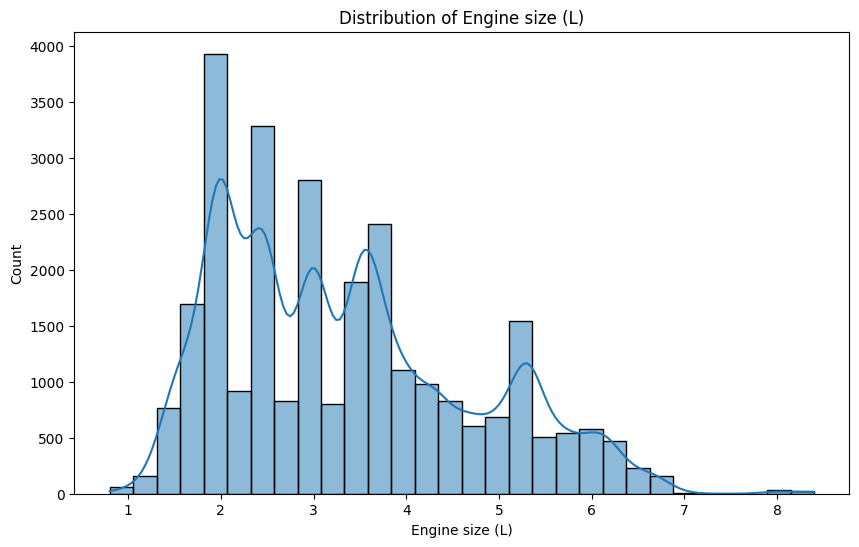

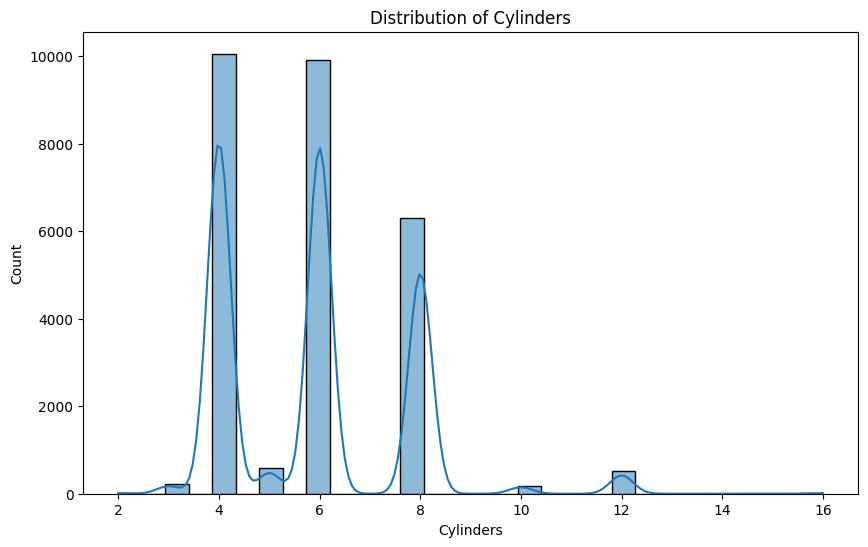

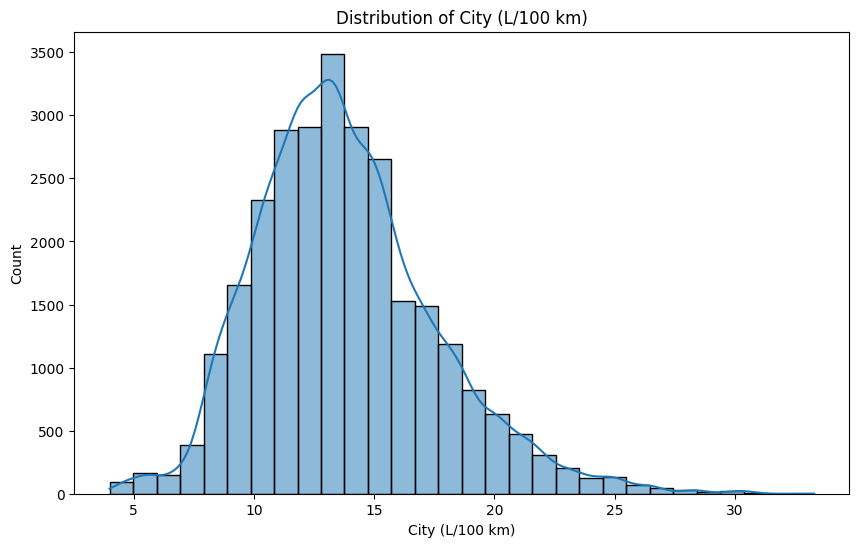

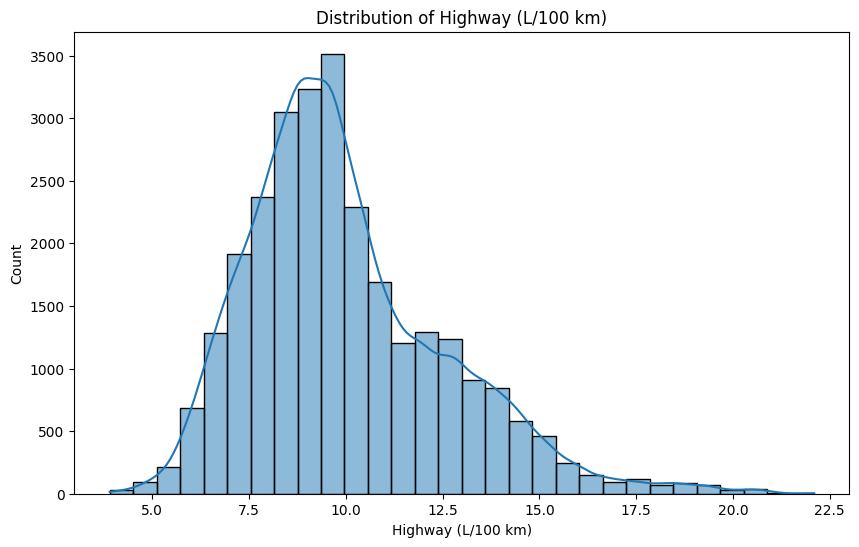

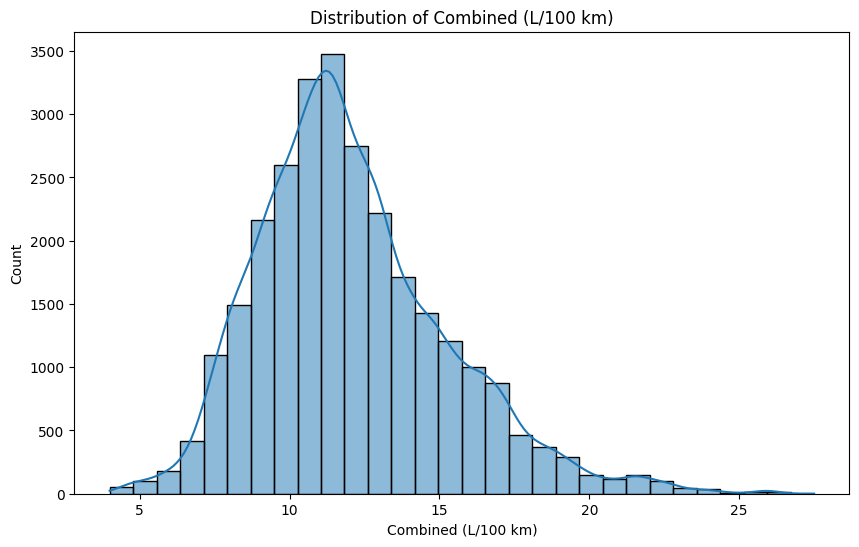

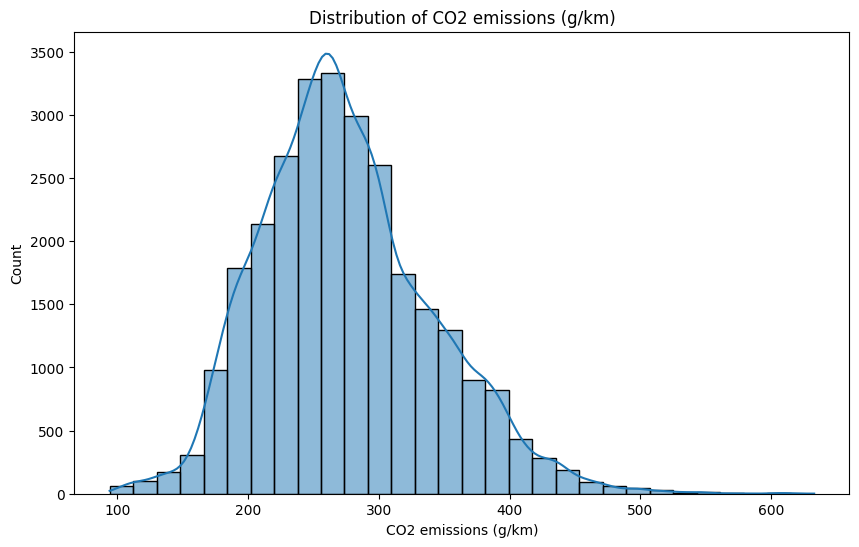

In [8]:
# the list of numerical columns here
numerical_columns = ['Engine size (L)', 'Cylinders', 'City (L/100 km)', 'Highway (L/100 km)', 'Combined (L/100 km)','CO2 emissions (g/km)']

# Plot distribution for each numerical feature
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

Anova Table

In [9]:
# ANOVA for categorical variables (hypothesis testing)
# Specify the columns to include in the ANOVA analysis
columns_for_anova = ['Make','Model','Vehicle class','Engine size (L)','Cylinders','Transmission','Fuel type','City (L/100 km)','Highway (L/100 km)']

# Add categorical columns to the list for ANOVA
columns_for_anova.extend(categorical_columns)

# Perform ANOVA
anova_results = {}
for col in columns_for_anova:
    # For categorical variables, perform ANOVA across the categories
    if col in categorical_columns:
        groups = [df['CO2 emissions (g/km)'][df[col] == category] for category in df[col].unique()]
        anova_results[col] = stats.f_oneway(*groups)
    # For numerical variables, perform ANOVA after categorizing the data
    else:
        df[col + '_cat'] = pd.qcut(df[col], q=4)  # Categorize into quartiles
        groups = [df['CO2 emissions (g/km)'][df[col + '_cat'] == category] for category in df[col + '_cat'].unique()]
        anova_results[col] = stats.f_oneway(*groups)

print("\nANOVA Results:")
for col, result in anova_results.items():
    print(f"{col}: F-statistic = {result.statistic:.2f}, p-value = {result.pvalue:.4f}")




ANOVA Results:
Make: F-statistic = 295.21, p-value = 0.0000
Model: F-statistic = 64.60, p-value = 0.0000
Vehicle class: F-statistic = 965.24, p-value = 0.0000
Engine size (L): F-statistic = 16051.99, p-value = 0.0000
Cylinders: F-statistic = 16170.87, p-value = 0.0000
Transmission: F-statistic = 237.18, p-value = 0.0000
Fuel type: F-statistic = 142.83, p-value = 0.0000
City (L/100 km): F-statistic = 35690.31, p-value = 0.0000
Highway (L/100 km): F-statistic = 33277.07, p-value = 0.0000


Z score and Ouliers

In [10]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Z-Score Method to identify outliers
z_scores = np.abs(zscore(df[numerical_cols]))
z_outliers = (z_scores > 3)

# Display outliers identified by Z-score
z_outlier_summary = pd.DataFrame(z_outliers, columns=numerical_cols)
print("Outliers identified by Z-Score method:")
print(z_outlier_summary.sum())

# IQR Method to identify outliers
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

iqr_outliers = (df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))

# Display outliers identified by IQR
iqr_outlier_summary = iqr_outliers.sum()
print("\nOutliers identified by IQR method:")
print(iqr_outlier_summary)

# Optional: Display rows with outliers in any column
outlier_rows = df[(z_outliers | iqr_outliers).any(axis=1)]
print("\nRows with outliers:")
print(outlier_rows)


Outliers identified by Z-Score method:
Model year                0
Engine size (L)          52
Cylinders               539
City (L/100 km)         235
Highway (L/100 km)      318
Combined (L/100 km)     261
Combined (mpg)          315
CO2 emissions (g/km)    140
dtype: int64

Outliers identified by IQR method:
Model year                0
Engine size (L)          52
Cylinders                16
City (L/100 km)         585
Highway (L/100 km)      600
Combined (L/100 km)     562
Combined (mpg)          442
CO2 emissions (g/km)    371
dtype: int64

Rows with outliers:
       Model year     Make                             Model  \
19           1995  Bentley                        Brooklands   
20           1995  Bentley                    Brooklands LWB   
21           1995  Bentley                       Continental   
22           1995  Bentley                 Continental Turbo   
23           1995  Bentley               Continental R Turbo   
...           ...      ...                    

Box Plot

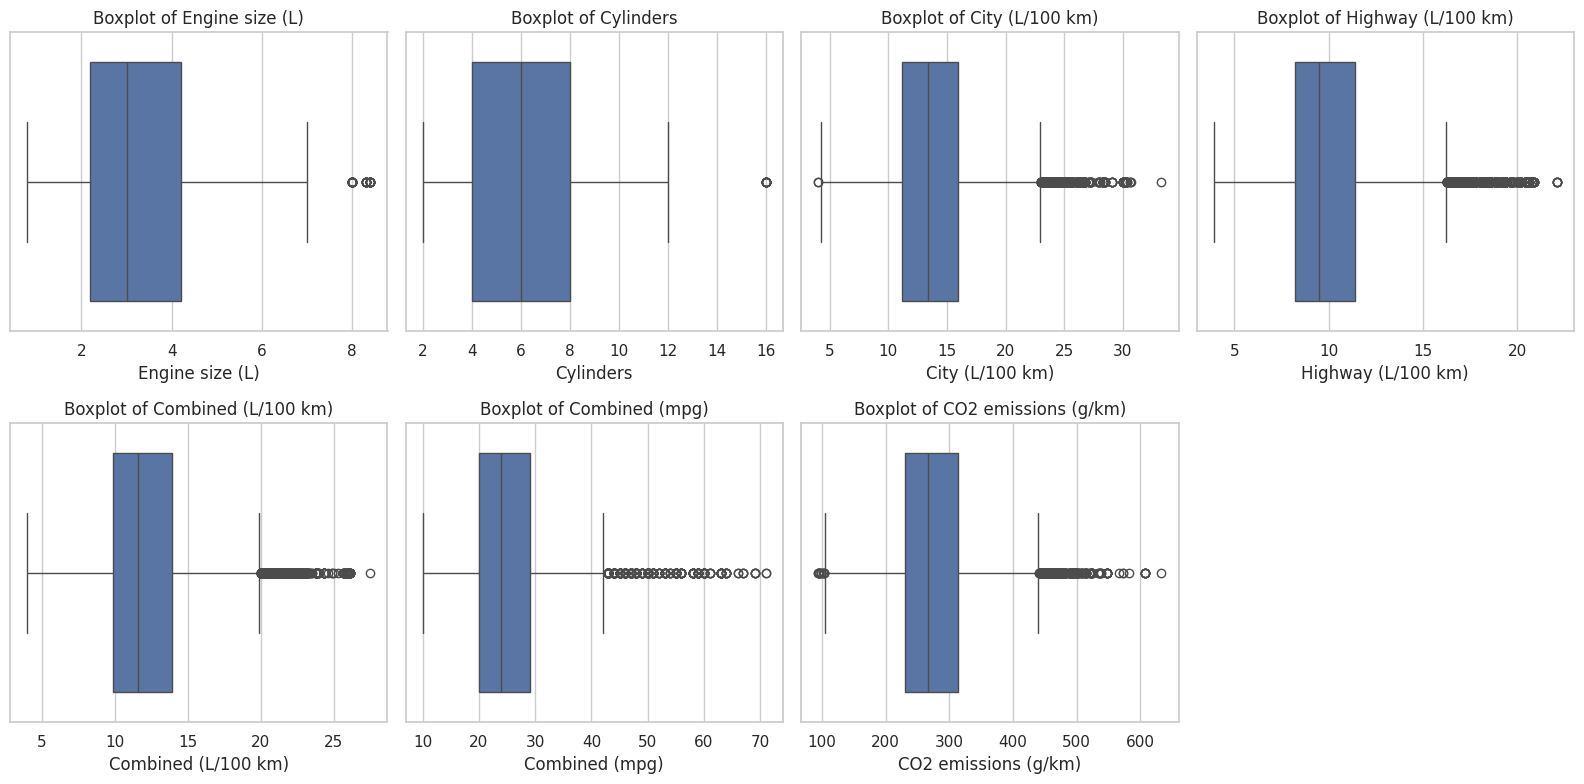

In [11]:
# Set plot style
sns.set(style="whitegrid")

# Visualizing outliers using Boxplots
def plot_boxplots(columns):
    num_plots = len(columns)
    num_rows = 2  # Number of rows in the subplot grid
    num_cols = (num_plots + 1) // 2  # Calculate number of columns, ensuring enough space

    plt.figure(figsize=(16, 8))
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)  # Use calculated number of rows and columns
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

# List of numerical columns to visualize
columns_to_plot = ['Engine size (L)', 'Cylinders', 'City (L/100 km)',
                   'Highway (L/100 km)', 'Combined (L/100 km)',
                   'Combined (mpg)', 'CO2 emissions (g/km)']

plot_boxplots(columns_to_plot)

Before treating and Log transformation

Selecting features,target and train_val_test

In [12]:
# Select features and target variable
# Assuming 'CO2 Emissions(g/km)' is the target variable
target = 'CO2 emissions (g/km)'  # Adjust if needed
features = ['Make','Model','Vehicle class','Engine size (L)','Cylinders','Transmission','Fuel type','City (L/100 km)','Highway (L/100 km)','Combined (L/100 km)']

# Split the data into train, validation, and test sets (80-10-10 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]


Modelling an Evaluation

Model: Linear Regression
Validation MAE: 2.271197086516924
Validation MSE: 20.886615940688266
Validation RMSE: 4.570187735825331
Validation R²: 0.9951642266813933
------------------------------
Model: Random Forest
Validation MAE: 0.8362024908498749
Validation MSE: 7.144629958939504
Validation RMSE: 2.6729440620670504
Validation R²: 0.9983458396982609
------------------------------
Model: XGBoost Regression
Validation MAE: 1.2859205392057713
Validation MSE: 5.8643372263859
Validation RMSE: 2.4216393675330563
Validation R²: 0.9986422594463747
------------------------------
Best Model: XGBoost Regression
Test MAE: 1.245610992585271
Test MSE: 4.086100896526677
Test RMSE: 2.0214106204645006
Test R²: 0.9990691936373496


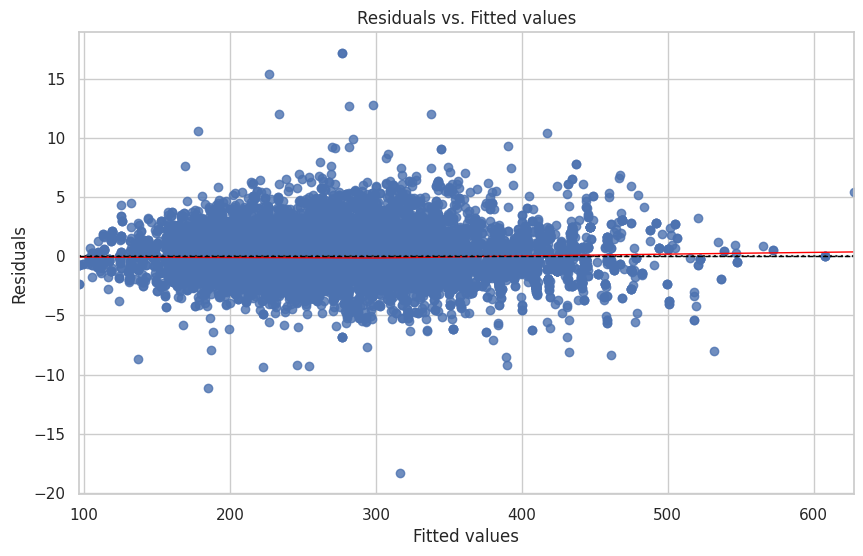

Cross-validated RMSE: 2.08545253879556 ± 0.10732601258499644


In [14]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)

}

# Initialize variables to track the best model
best_model = None
best_model_name = None
best_rmse = float('inf')

# Train, validate, and evaluate models
for name, model in models.items():
    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Validation
    y_val_pred = pipeline.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_val_pred)

    # Print validation results for each model
    print(f"Model: {name}")
    print(f"Validation MAE: {val_mae}")
    print(f"Validation MSE: {val_mse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Validation R²: {val_r2}")
    print("-" * 30)

    # Track the best model based on RMSE
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = pipeline
        best_model_name = name

# Final model is the one with the best validation performance
print(f"Best Model: {best_model_name}")

# Train the final model on the entire training set (training + validation)
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', models[best_model_name])])
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Test the model
y_test_pred = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")


# Residuals vs. Fitted Plot
y_train_val_pred = final_model.predict(pd.concat([X_train, X_val]))
residuals = pd.concat([y_train, y_val]) - y_train_val_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_val_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.show()

# Cross-Validation
cv_rmse = -cross_val_score(final_model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]),
                           cv=5, scoring='neg_root_mean_squared_error')

print(f"Cross-validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")


Treating Outliers

In [15]:
#Min Max Scaling
scaler = MinMaxScaler(feature_range=(0,6))  # Adjust the range as needed
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [16]:
# Log transformation on fuel consumption metrics
df['City (L/100 km)'] = np.log1p(df['City (L/100 km)'])
df['Highway (L/100 km)'] = np.log1p(df['Highway (L/100 km)'])
df['Combined (L/100 km)'] = np.log1p(df['Combined (L/100 km)'])

# Capping CO2 emissions at the 99th percentile
cap = np.percentile(df['CO2 emissions (g/km)'], 99)
df['CO2 emissions (g/km)'] = np.where(df['CO2 emissions (g/km)'] > cap, cap, df['CO2 emissions (g/km)'])


Box Plot

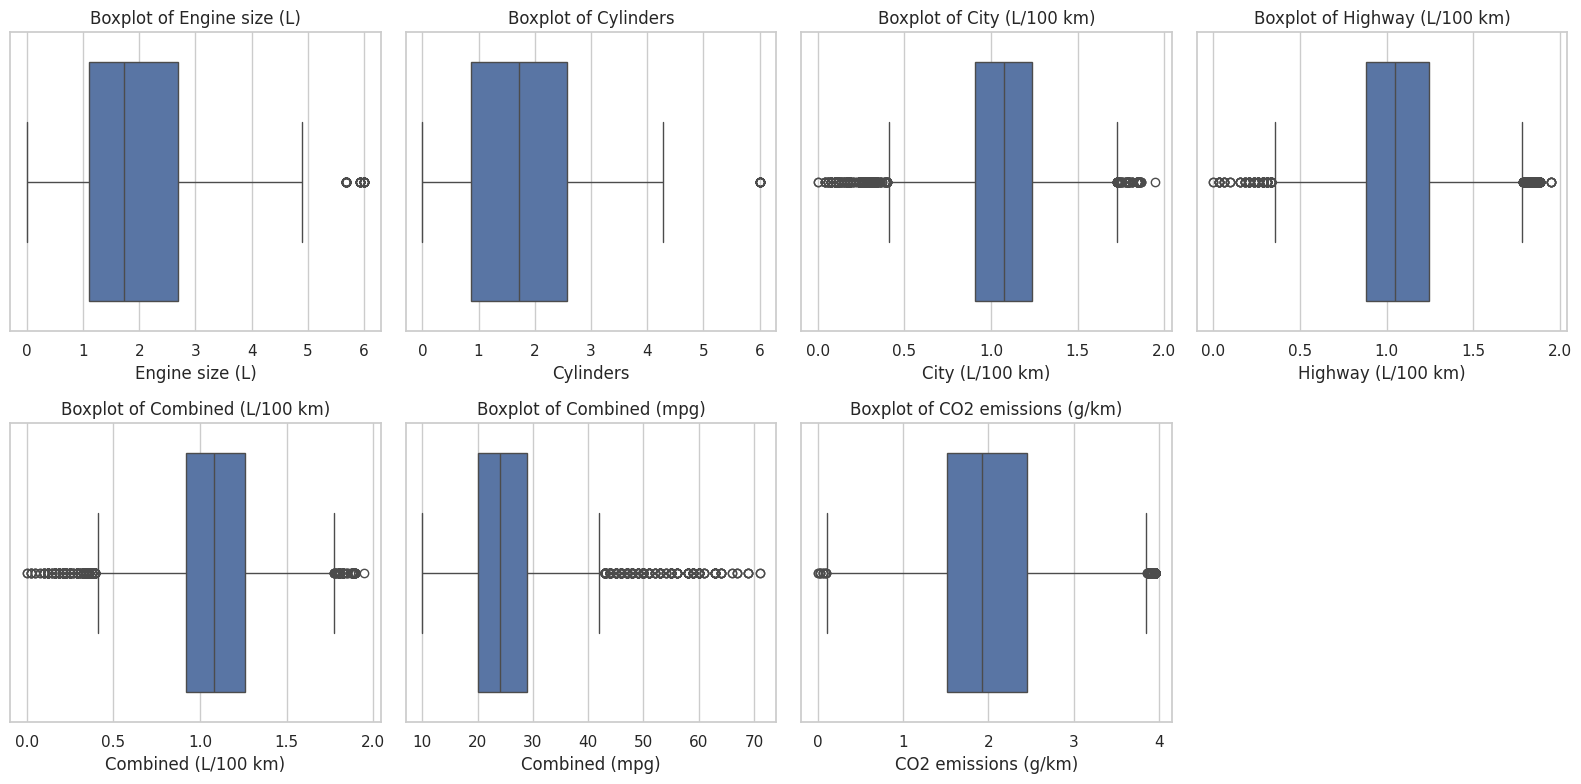

In [17]:
# Set plot style
sns.set(style="whitegrid")

# Visualizing outliers using Boxplots
def plot_boxplots(columns):
    num_plots = len(columns)
    num_rows = 2  # Number of rows in the subplot grid
    num_cols = (num_plots + 1) // 2  # Calculate number of columns, ensuring enough space

    plt.figure(figsize=(16, 8))
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_cols, i)  # Use calculated number of rows and columns
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

# List of numerical columns to visualize
columns_to_plot = ['Engine size (L)', 'Cylinders', 'City (L/100 km)',
                   'Highway (L/100 km)', 'Combined (L/100 km)',
                   'Combined (mpg)', 'CO2 emissions (g/km)']

plot_boxplots(columns_to_plot)

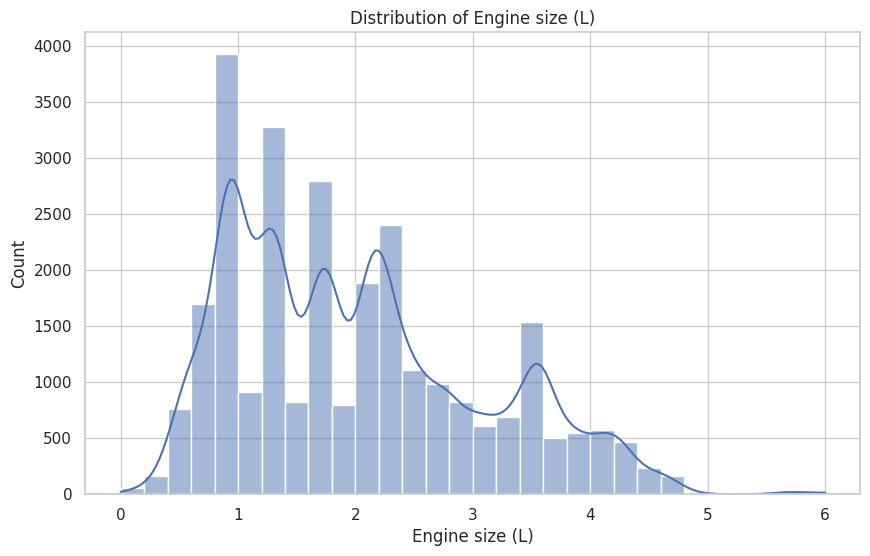

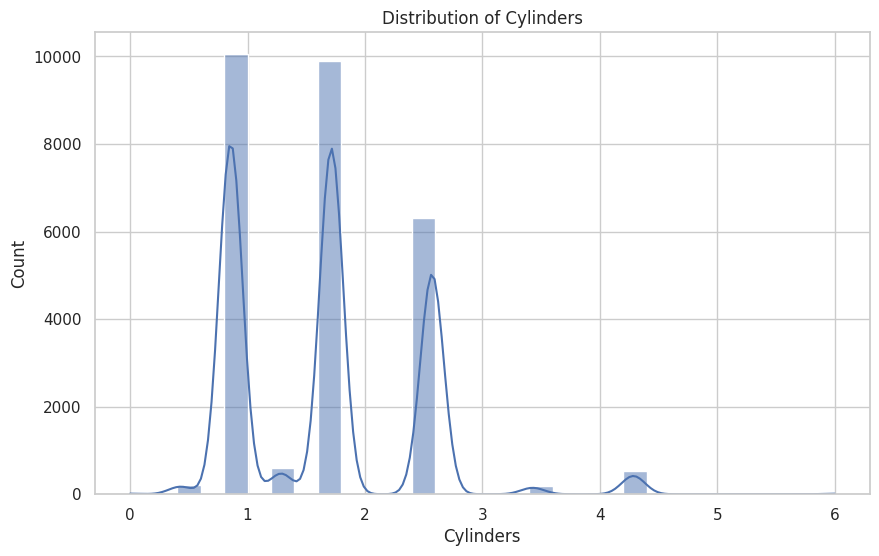

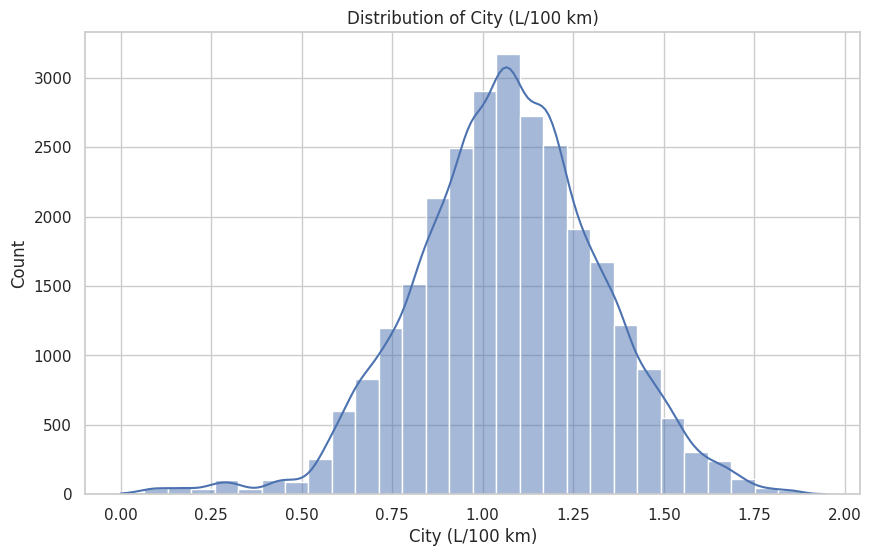

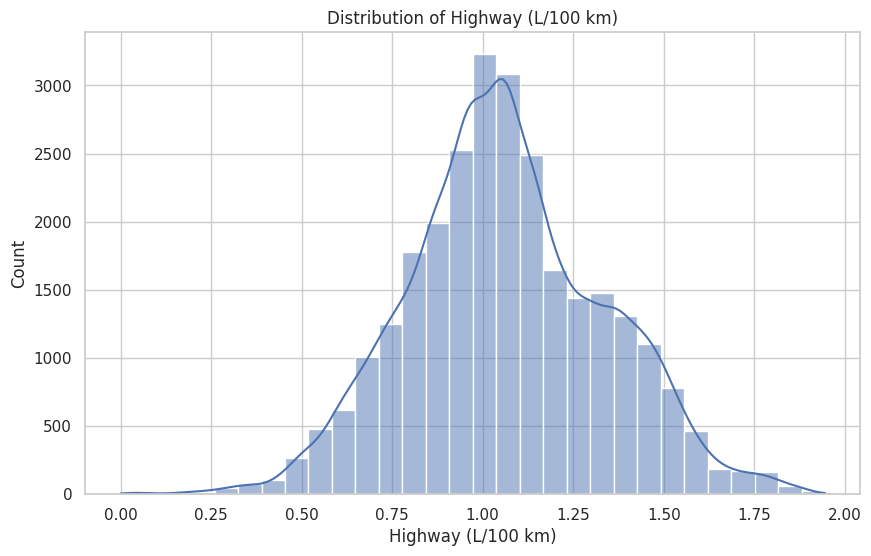

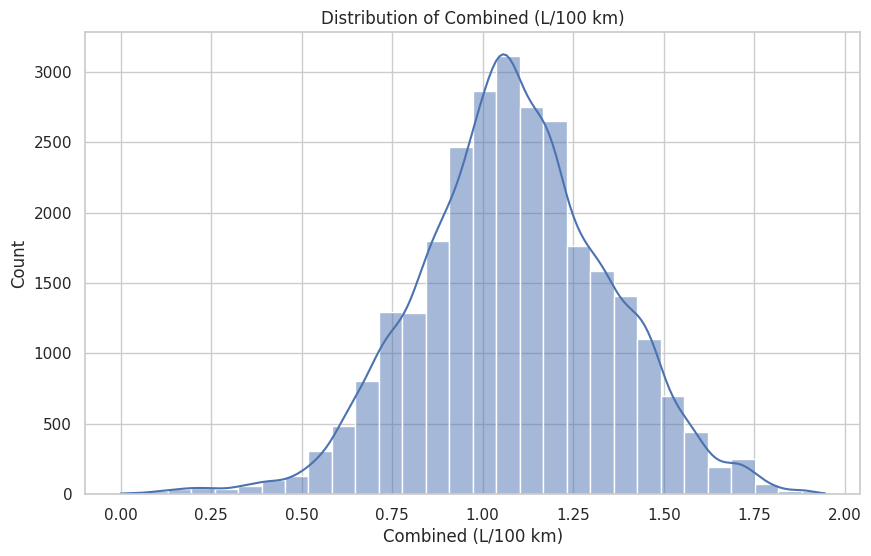

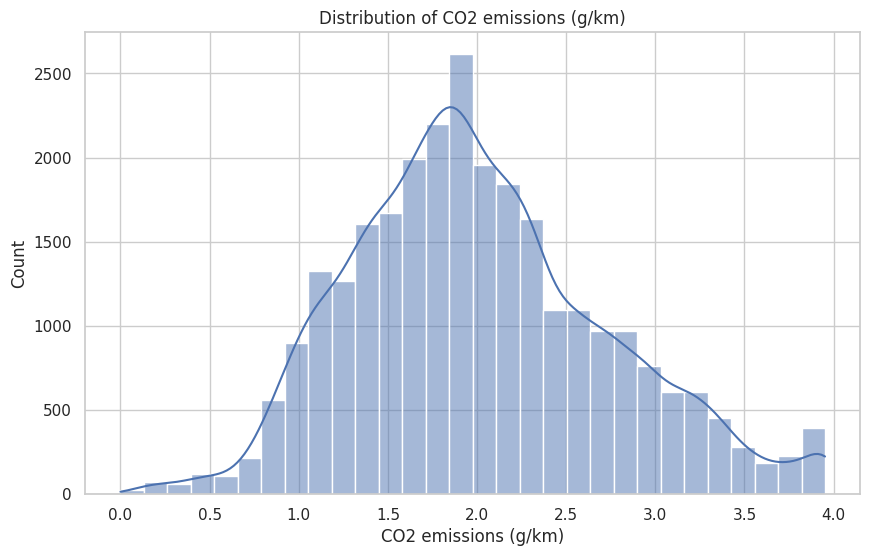

In [18]:
# the list of numerical columns here
numerical_columns = ['Engine size (L)', 'Cylinders', 'City (L/100 km)', 'Highway (L/100 km)', 'Combined (L/100 km)','CO2 emissions (g/km)']

# Plot distribution for each numerical feature
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

Other important plots

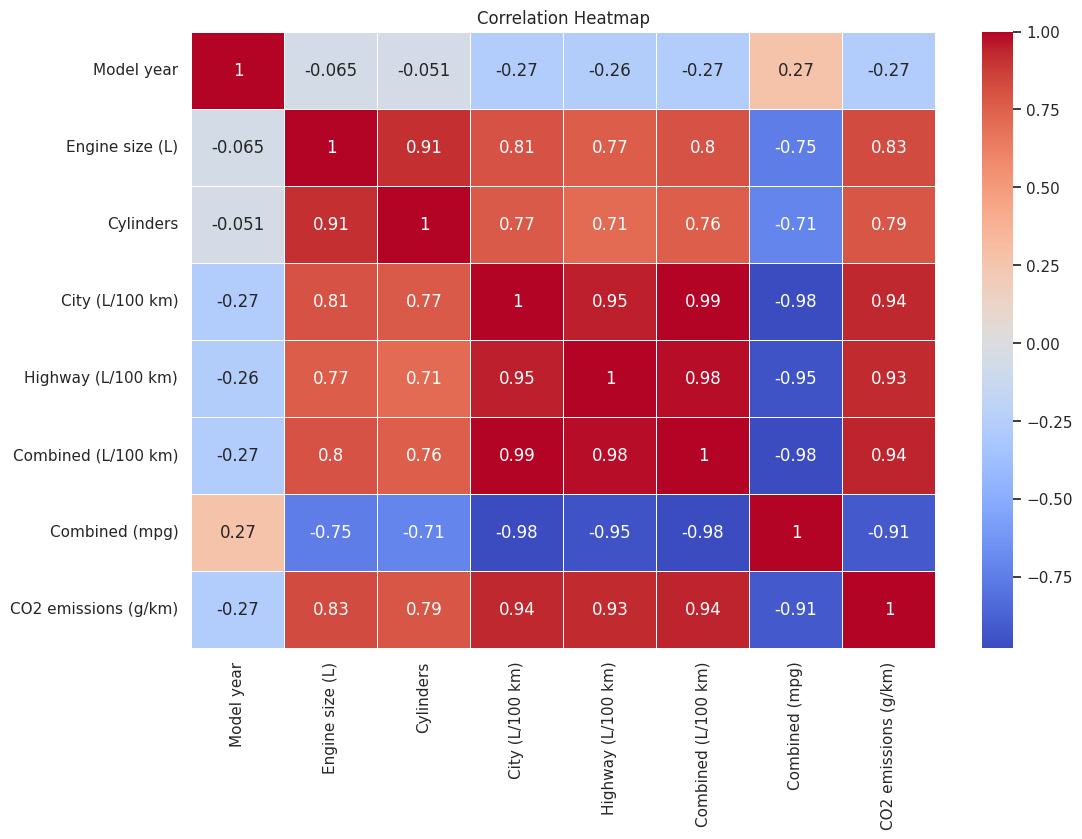

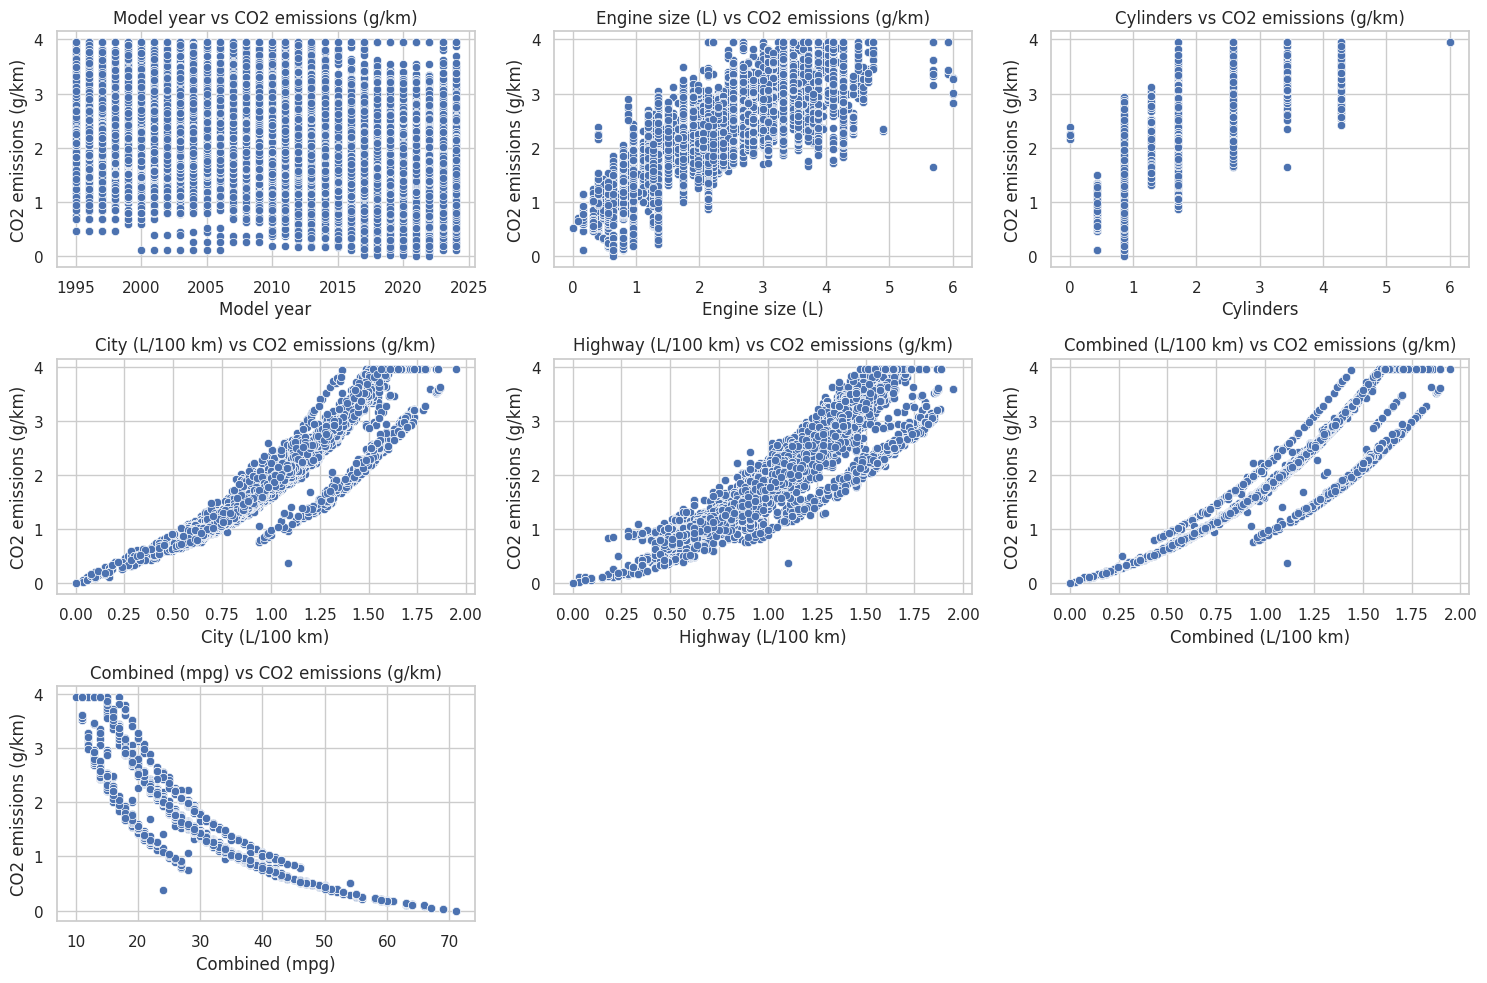

In [19]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots of CO2 Emissions against other numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('CO2 emissions (g/km)')
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=df[col], y=df['CO2 emissions (g/km)'])
    plt.title(f'{col} vs CO2 emissions (g/km)')
    plt.xlabel(col)
    plt.ylabel('CO2 emissions (g/km)')
plt.tight_layout()
plt.show()


After treating Outliers and Handling them

Selecting features,target and train_val_test

In [20]:
# Select features and target variable
# Assuming 'CO2 Emissions(g/km)' is the target variable
target = 'CO2 emissions (g/km)'  # Adjust if needed
features = ['Make','Model','Vehicle class','Engine size (L)','Cylinders','Transmission','Fuel type','City (L/100 km)','Highway (L/100 km)','Combined (L/100 km)']

# Split the data into train, validation, and test sets (80-10-10 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]


Modelling an Evaluation

Model: Linear Regression
Validation MAE: 0.03595323344399192
Validation MSE: 0.0033050938939904943
Validation RMSE: 0.05748994602528771
Validation R²: 0.9936764989561343
------------------------------
Model: XGBoost Regression
Validation MAE: 0.013758636763142368
Validation MSE: 0.0007932397206462596
Validation RMSE: 0.028164511723909925
Validation R²: 0.9984823268680315
------------------------------
Model: Random Forest
Validation MAE: 0.008858528939964522
Validation MSE: 0.0007973550255251468
Validation RMSE: 0.028237475551563508
Validation R²: 0.9984744532234295
------------------------------
Best Model: XGBoost Regression
Test MAE: 0.01321795062735505
Test MSE: 0.0004511268757087111
Test RMSE: 0.021239747543431657
Test R²: 0.99913051863733


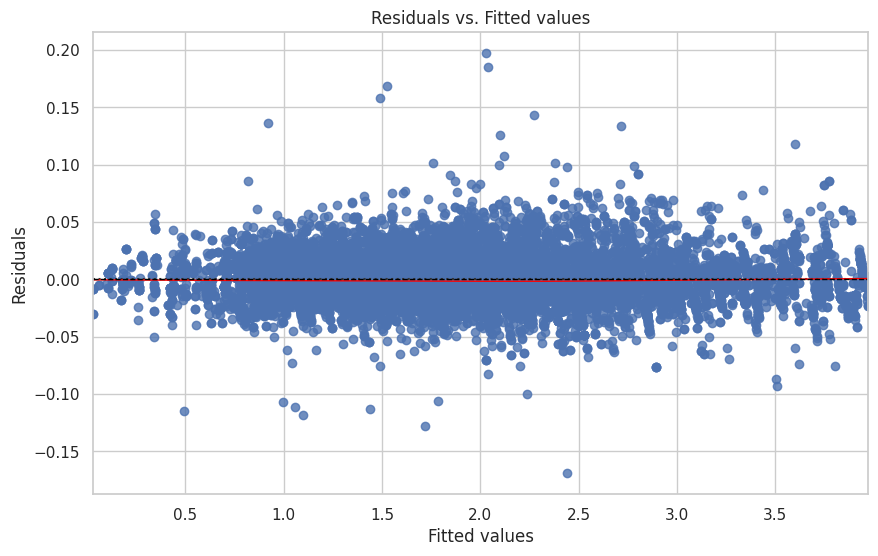

Cross-validated RMSE: 0.022577612508845907 ± 0.0016004608569123223


In [43]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'model__n_estimators': [250, 300, 450],
    'model__max_depth': [4,5, 7],
    'model__learning_rate': [0.075, 0.05, 0.1],
    'model__subsample': [0.8, 0.9],
    'model__colsample_bytree': [0.8, 0.9],
    'model__gamma': [0.1, 0.2]

}

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost Regression': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),

}

# Initialize variables to track the best model
best_model = None
best_model_name = None
best_rmse = float('inf')

# Train, validate, and evaluate models
for name, model in models.items():
    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Validation
    y_val_pred = pipeline.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_val_pred)

    # Print validation results for each model
    print(f"Model: {name}")
    print(f"Validation MAE: {val_mae}")
    print(f"Validation MSE: {val_mse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Validation R²: {val_r2}")
    print("-" * 30)

    # Track the best model based on RMSE
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = pipeline
        best_model_name = name

# Final model is the one with the best validation performance
print(f"Best Model: {best_model_name}")

# Train the final model on the entire training set (training + validation)
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', models[best_model_name])])
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Test the model
y_test_pred = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")


# Residuals vs. Fitted Plot
y_train_val_pred = final_model.predict(pd.concat([X_train, X_val]))
residuals = pd.concat([y_train, y_val]) - y_train_val_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_train_val_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.show()

# Cross-Validation
cv_rmse = -cross_val_score(final_model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]),
                           cv=5, scoring='neg_root_mean_squared_error')

print(f"Cross-validated RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")


Learning Curve

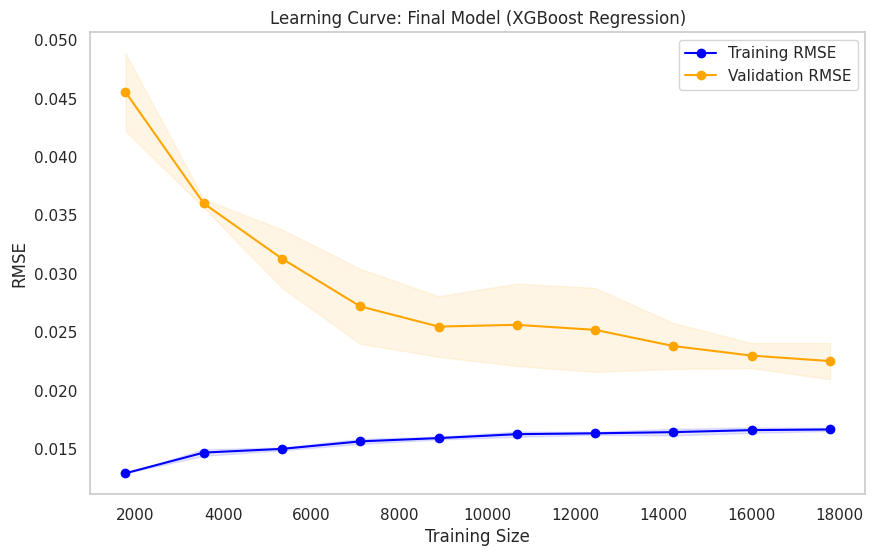

In [44]:
# Function to plot learning curves for the best model
def plot_learning_curve(model, X, y, model_name, preprocessor=None):
    if preprocessor is not None:
        model = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training RMSE')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Validation RMSE')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color='orange')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curve for the final model
plot_learning_curve(models[best_model_name], pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), f'Final Model ({best_model_name})', preprocessor)
